Project: # Patil_ADEarlyDetection

# **Phase 1:**  
## CNN with TL = DenseNet121

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/AD_proj"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Alzheimer_s_Dataset  my_best_models


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.applications.densenet import  DenseNet169, DenseNet121, DenseNet201 #https://keras.io/api/applications/densenet/
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import IPython
import time

from matplotlib import pyplot as plt

import sys
sys.path.append('/content/drive/My Drive/AD_proj')

#
# Define constants
#
NUM_EPOCH = 100
NUM_PATIENCE =20
NUM_VAL_SPLIT = 0.2
NUM_IMG_RESCALE = 1/255
NUM_BATCH_SIZE = 128
NUM_IMAGE_SIZE =224
NUM_LEARNING_RATE = 0.001

In [ ]:
train = ImageDataGenerator(validation_split=NUM_VAL_SPLIT,
                           rotation_range=40,
                           zoom_range=0.2,
                           horizontal_flip=True, 
                           vertical_flip=True, 
                           rescale=NUM_IMG_RESCALE)

validation = ImageDataGenerator(validation_split=NUM_VAL_SPLIT, rescale=NUM_IMG_RESCALE)

test = ImageDataGenerator(rescale=NUM_IMG_RESCALE)

train_dataset = train.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/train', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical', 
    subset='training')
val_dataset = validation.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/train', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical', 
    subset='validation')

test_dataset = test.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/test', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical')

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
#--------------------------------------------------------------------
# Function Name: f_ad_model_builder
# Description: Build Convolutional Neural Network (CNN) Deep learning model
#              for early diagnosis of Alzheimer's disease
# Output : 4 output classes 
#--------------------------------------------------------------------
def f_ad_model_builder():
    
  #Create CNN model using Transfer Learning using DenseNet 
  # Set include tope=False, so fully-connected output layers of the model used to make predictions is not loaded, allowing a new output layer to be added and trained
  #model_densenet169 = DenseNet169(input_shape=(NUM_IMAGE_SIZE,NUM_IMAGE_SIZE,3), include_top=False, weights="imagenet")
  model_cnn_tl = DenseNet121(input_shape=(NUM_IMAGE_SIZE,NUM_IMAGE_SIZE,3), include_top=False, weights="imagenet")
  # freeze layers
  for layer in model_cnn_tl.layers :
    layer.trainable = False

  model = Sequential()
  model.add(model_cnn_tl)
  model.add(Dropout(0.5))

  model.add(Flatten())
  
  model.add(BatchNormalization())
  model.add(Dense(2048,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4,activation='softmax'))

  model.summary()

  #
  # COMPILE: Tune the learning rate for the optimizer value choice 
  # from 0.01, 0.001, or 0.0001
  # 
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = NUM_LEARNING_RATE),
                loss = 'categorical_crossentropy', 
                metrics = [tf.keras.metrics.AUC(name = 'auc')])
  
  return model

#--------------------------------------------------------------------
# Function Name: f_all_ad_plot_model
# Description: 
#              
#--------------------------------------------------------------------
def f_ad_all_plot_model(hist):

    plt.plot(hist.history["acc"])
    plt.plot(hist.history['val_acc'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("AD Early Detection Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation Loss"])

    # Show the plot
    plt.show()

#--------------------------------------------------------------------
# Function Name: f_ad_plot_auc_loss
# Description: 
#              
#--------------------------------------------------------------------
def f_ad_plot_auc_loss(f_model):

  # create subplots
  fig, axs = plt.subplots(1,2,figsize=(15,10))

  ticks = np.arange(1,len(f_model.history['loss'])+1)
  history_auc_length = len(f_model.history['auc'])+1
  history_val_auc_length = len(f_model.history['val_auc'])+1
  history_loss_length = len(f_model.history['loss'])+1
  history_val_loss_length = len(f_model.history['val_loss'])+1

  # Summarize history for auc
  axs[0].plot(range(1,history_auc_length), f_model.history['auc'])
  axs[0].plot(range(1,history_val_auc_length), f_model.history['val_auc'])
  axs[0].set_title('Model AUC')
  axs[0].set_ylabel('AUC')
  axs[0].set_xlabel('Epoch')
  axs[0].set_xticks(ticks,len(f_model.history['auc'])/10)
  axs[0].legend(['train', 'val'], loc='best', bbox_to_anchor=(1,1))

  # Summarize history for loss
  axs[1].plot(range(1, history_loss_length), f_model.history['loss'])
  axs[1].plot(range(1,history_val_loss_length), f_model.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].set_xticks(ticks,len(f_model.history['loss'])/10)
  axs[1].legend(['train', 'val'], loc='best', bbox_to_anchor=(1,1))

#--------------------------------------------------------------------
# Function Name: 
# Description: 
#              
#--------------------------------------------------------------------
# ??? how to calculate fpr/tpr
def f_ad_plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, 'b',color='orange', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate (FPR) ')
    plt.ylabel('True Positive Rate (TPR) ')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc = 'lower right')
    plt.show()
#--------------------------------------------------------------------
# Function Name: f_ad_plot_model
# Description: 
#              
#--------------------------------------------------------------------
def f_ad_plot_acc_loss(f_model):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,10))
    ticks = np.arange(1,len(f_model.history['loss'])+1)
    history_acc_length = len(f_model.history['accuracy'])+1
    history_val_accuracy_length = len(f_model.history['val_accuracy'])+1
    history_loss_length = len(f_model.history['loss'])+1
    history_val_loss_length = len(f_model.history['val_loss'])+1

    # Summarize history for accuracy
    axs[0].plot(range(1,history_acc_length), f_model.history['accuracy'])
    axs[0].plot(range(1,history_val_accuracy_length), f_model.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(ticks,len(f_model.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1, history_loss_length), f_model.history['loss'])
    axs[1].plot(range(1,history_val_loss_length), f_model.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(ticks,len(f_model.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50176)             200704    
_________________________________________________________________
dense (Dense)                (None, 2048)              102762496 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


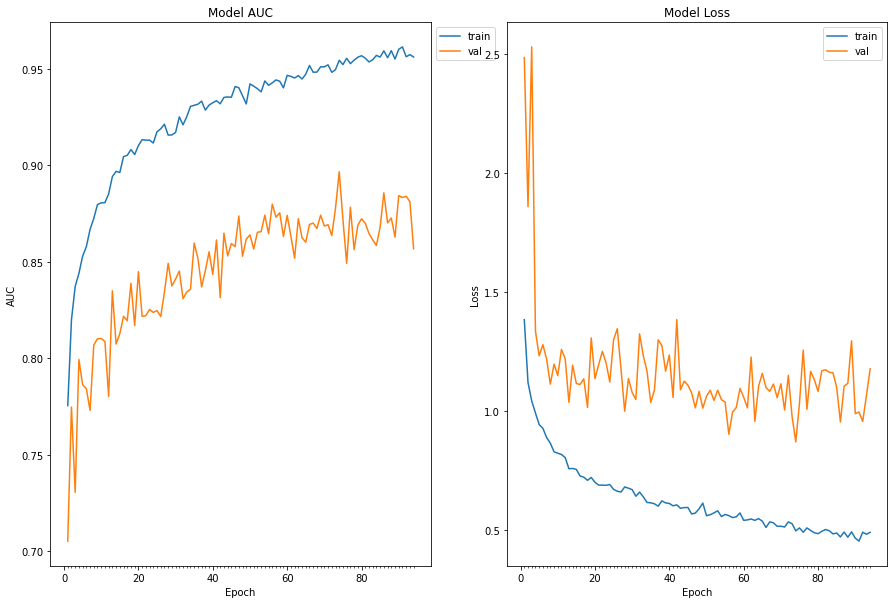

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/AD_proj/my_best_models/densenet121_rev0.hdf5", monitor='val_auc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_auc', min_delta=0, patience=NUM_PATIENCE, verbose=1, mode='max') 

model = f_ad_model_builder()
tic = time.perf_counter()
model_history=model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs = NUM_EPOCH,
                        callbacks = [checkpoint, early],
                        verbose = 2)

#model_history.predict()
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

print('--------------------------------------------\n')
print('Results [with DenseNet121]:')
f_ad_plot_auc_loss(model_history)